# Octank IIoT Data Analytics Notebook
Demonstration of [AWS IoT Analytics](https://aws.amazon.com/iot-analytics/) Notebooks, using real-time sensor data.

In [1]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    x = pd.to_numeric(x, downcast="float")
    return pd.Timestamp(x, unit="s")

In [3]:
%%time

client = boto3.client("iotanalytics")
dataset = "iot_data_dataset"
data_location = client.get_dataset_content(datasetName = dataset)["entries"][0]["dataURI"]
df = pd.read_csv(data_location,
                      header=0, 
                      low_memory=False, 
                      infer_datetime_format=True, 
                      date_parser=parse,
                      index_col=["ts"])

CPU times: user 52.9 s, sys: 1.27 s, total: 54.2 s
Wall time: 54.5 s


In [4]:
df = df.drop(columns="__dt")

In [5]:
print(df.tail(5))

                                 device   humidity       temp  light  motion  \
ts                                                                             
2020-06-22 15:47:12  iot-demo-device-03  57.500000  72.500000   True   False   
2020-06-22 15:47:12  iot-demo-device-02  73.199997  64.039999   True   False   
2020-06-22 15:47:12  iot-demo-device-03  57.400002  72.500000   True   False   
2020-06-22 15:47:12  iot-demo-device-02  73.199997  64.039999   True   False   
2020-06-22 15:47:12  iot-demo-device-01  86.599998  62.419999  False   False   

                          lpg        co     smoke  
ts                                                 
2020-06-22 15:47:12  0.007996  0.005267  0.021395  
2020-06-22 15:47:12  0.006631  0.004067  0.017519  
2020-06-22 15:47:12  0.008005  0.005276  0.021423  
2020-06-22 15:47:12  0.006631  0.004067  0.017519  
2020-06-22 15:47:12  0.009784  0.006963  0.026543  


In [6]:
print("Dataset Range")
print("-------------")
print("Record count: {:,}".format(df["temp"].count()))
print("Time range (min): {:%Y-%m-%d %H:%M:%S UTC}".format(df.index[-1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S UTC}".format(df.index[1]))
print("Records:\n{}".format(df.groupby("device").size()))

Dataset Range
-------------
Record count: 538,581
Time range (min): 2020-06-22 15:47:12 UTC
Time range (max): 2020-06-27 01:29:36 UTC
Records:
device
iot-demo-device-01    156874
iot-demo-device-02    153310
iot-demo-device-03    228397
dtype: int64


In [30]:
%%time

df_filtered = df.sort_values(ascending=False, by="ts").head(25000)

# df_filtered = df_filtered[df_filtered.temp > df_filtered.temp.quantile(.01)]
# df_filtered = df_filtered[df_filtered.temp < df_filtered.temp.quantile(.99)]
# df_filtered = df_filtered[df_filtered.humidity > df_filtered.humidity.quantile(.01)]
# df_filtered = df_filtered[df_filtered.humidity < df_filtered.humidity.quantile(.99)]

df_filtered = df_filtered.loc[df_filtered["temp"] > df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["temp"] < df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.99))]
df_filtered = df_filtered.loc[df_filtered["humidity"] > df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["humidity"] < df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.99))]

groups = df_filtered.groupby("device")

CPU times: user 122 ms, sys: 122 µs, total: 122 ms
Wall time: 67 ms


In [31]:
print("Dataset Range")
print("-------------")
print("Trimmed record count: {:,}".format(df_filtered["temp"].count()))
print("Time range (min): {:%Y-%m-%d %H:%M:%S UTC}".format(df_filtered.index[-1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S UTC}".format(df_filtered.index[1]))
print("Temperature (min): {:.2f}".format(df_filtered["temp"].min()))
print("Temperature (max): {:.2f}".format(df_filtered["temp"].max()))
print("Humidity (min): {:.2f}{}".format(df_filtered["humidity"].min(),"%"))
print("Humidity (max): {:.2f}{}".format(df_filtered["humidity"].max(),"%"))
print("Records:\n{}".format(groups.size()))

Dataset Range
-------------
Trimmed record count: 25,000
Time range (min): 2020-07-06 06:02:40 UTC
Time range (max): 2020-07-06 18:14:24 UTC
Temperature (min): 33.26
Temperature (max): 82.94
Humidity (min): 3.50%
Humidity (max): 73.40%
Records:
device
iot-demo-device-01     7212
iot-demo-device-02     6415
iot-demo-device-03    11373
dtype: int64


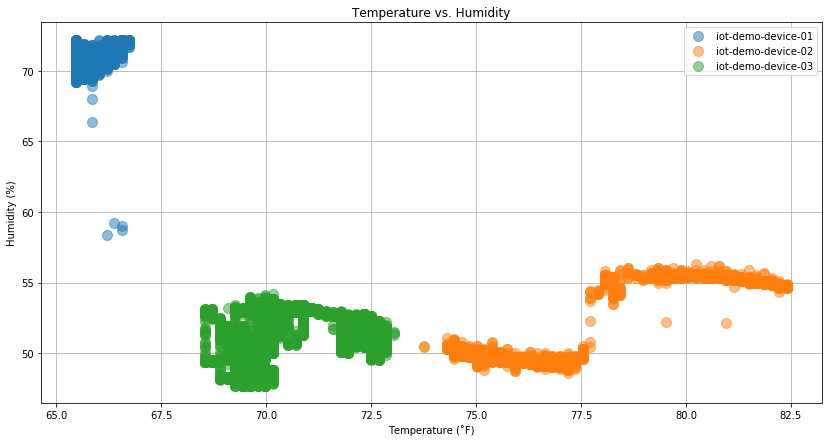

In [9]:
_, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.temp, 
            group.humidity, 
            marker="o", 
            linestyle="", 
            alpha=.5,
            ms=10, 
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature vs. Humidity")
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

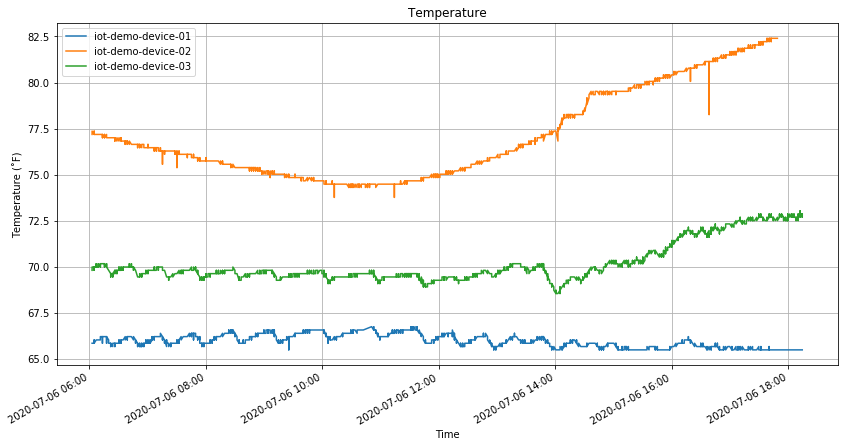

In [10]:
register_matplotlib_converters()
myFmt = DateFormatter("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.temp,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature")
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()

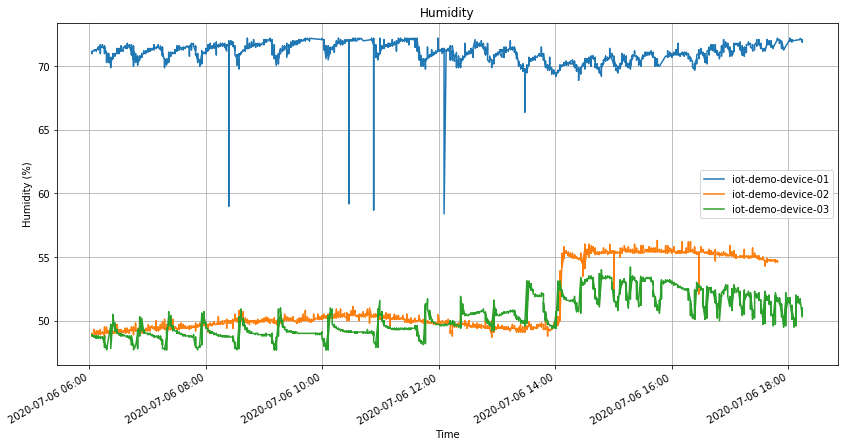

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
for device, group in groups:
    ax.plot(group.humidity,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Humidity")
plt.ylabel("Humidity (%)")
plt.xlabel("Time")
plt.show()